In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert import focuss
pp = dict(surface='white', hemi='both')

# Get Forward Model

In [2]:
info = get_info(kind='biosemi256')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


# Get sample data

In [3]:
settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=9999999)
# settings = dict(number_of_sources=3, extents=(25, 40), duration_of_trial=0.01, target_snr=9999999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
M = evoked.data

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

# Minimum Norm Estimate

In [285]:
alpha = 0.001
# if n_chans>n_dipoles:
# D_MNE = np.linalg.inv(leadfield.T @ leadfield + alpha * np.identity(n_dipoles)) @ leadfield.T @ M
# else:
D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

stc_hat = stc.copy()
stc_hat.data = D_MNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted', 'title',
               font_size=14)

Using control points [1.71317947e-10 3.71512281e-10 4.85990987e-09]
Using control points [1.84714643e-10 2.32652930e-10 8.30648699e-10]


# Weighted Minimum Norm Estimate

In [286]:
alpha = 0.001
omega = np.diag(np.linalg.norm(leadfield, axis=0))
I_3 = np.identity(3)
W = omega # np.kron(omega, I_3)

D_WMNE = np.linalg.inv(W.T @ W) @ leadfield.T  @ np.linalg.inv(leadfield @ np.linalg.inv(W.T @ W) @ leadfield.T + alpha * np.identity(n_chans)) @ M

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

stc_hat = stc.copy()
stc_hat.data = D_WMNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted', 'title',
               font_size=14)

Using control points [1.71317947e-10 3.71512281e-10 4.85990987e-09]
Using control points [1.03314764e-10 1.33961572e-10 5.63678825e-10]


# MNE with FOCUSS (Focal underdetermined system solution)

## Focalization based on first time point only (probably wrong)

In [191]:
alpha = 0.001
omega = np.diag(np.linalg.norm(leadfield, axis=0))
I_3 = np.identity(3)
W = omega # np.kron(omega, I_3)
t = 0
n_reps = 3
# Start by initializing W_0
D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M
D_Last = deepcopy(D_MNE)
    
W_0 = np.diag(D_MNE[:, t])
w_i = np.diag(1/np.linalg.norm(leadfield, axis=0))
# W_i = w_i @ W_0 @ np.diag(D_MNE[:, t])
W_i = W_0  # w_i @ W_0 @ np.diag(D_MNE[:, t])



for i in range(n_reps):
    print(f'{i}/{n_reps}')
    
    D_FOCUSS = W_i @ W_i.T @ leadfield.T @ np.linalg.inv(leadfield @ W_i @ W_i.T @ leadfield.T + alpha * np.identity(n_chans)) @ M
    W_i = w_i @ W_i @ np.diag(D_FOCUSS[:, t])
    if np.linalg.norm(D_FOCUSS) == 0:
        D_FOCUSS = D_Last
        print(f"converged at repetition {i+1}")
        break
    else:
        D_Last = deepcopy(D_FOCUSS)


brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

0/3
1/3
2/3
converged at repetition 3
Using control points [7.11032017e-11 2.10613134e-10 5.73677564e-09]
Using control points [4.51700919e-63 4.64621945e-62 1.45653351e-55]


## Focalization based on all time points

In [4]:
alpha = 0.001

D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M
D_FOCUSS = focuss(D_MNE, M, leadfield, alpha)
# print("FOCUSS:\n")
# D_FOCUSS = np.zeros(D_MNE.shape)
# for t in range(D_MNE.shape[1]):
#     i = 0
#     # Start by initializing W_0
    
#     D_Last = deepcopy(D_MNE)
        
#     W_0 = np.diag(D_MNE[:, t])
#     w_i = np.diag(1/np.linalg.norm(leadfield, axis=0))
#     # W_i = w_i @ W_0 @ np.diag(D_MNE[:, t])
#     W_i = W_0

#     while True:
#         print(f'Iteration {i}')
        
#         D_FOCUSS_t = W_i @ W_i.T @ leadfield.T @ np.linalg.inv(leadfield @ W_i @ W_i.T @ leadfield.T + alpha * np.identity(n_chans)) @ M[:, t][:, np.newaxis]
#         W_i = w_i @ W_i @ np.diag(D_FOCUSS_t[:, 0])
#         if np.linalg.norm(D_FOCUSS_t) == 0:
#             D_FOCUSS_t = D_Last
#             print(f"converged at repetition {i+1}")
#             D_FOCUSS[:, t] = D_FOCUSS_t[:, 0]
#             break
#         else:
#             D_Last = deepcopy(D_FOCUSS_t)
#         i += 1


brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Iteration 0
Iteration 1
Iteration 2
converged at repetition 3
Using pyvista 3d backend.

Using control points [3.41685409e-12 1.38539530e-11 7.38356273e-10]
Using control points [2.76370138e-71 2.35068440e-70 2.35359852e-64]
0.2514455349197196


[0.2515512197340774,
 0.2514267972551438,
 0.25144484062611366,
 0.25144622921332554,
 0.25145946922256984,
 0.2513805091766351,
 0.25133766219325493,
 0.2514439214665536,
 0.25148032716568197,
 0.25147405687364194]

Using control points [1.58034015e-77 1.53958787e-76 6.43315576e-71]


# LORETA

In [7]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
# D_LOR = np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ (leadfield @ np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T + alpha * np.identity(n_chans) ) @ M
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

stc_hat = stc.copy()
stc_hat.data = D_LOR
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted', 'title',
            font_size=14)



-- number of adjacent vertices : 1284
Using control points [3.41685409e-12 1.38539530e-11 7.38356273e-10]
Using control points [4.40850535e-11 5.95290291e-11 3.34429137e-10]


# LORETA FOCUSS

In [6]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
D_FOCUSS = focuss(D_LOR, M, leadfield, alpha)

# print("FOCUSS:\n")
# for t in range(D_LOR.shape[1]):
#     i = 0
#     # Start by initializing W_0
#     D_FOCUSS_t = np.zeros(D_LOR.shape)
#     D_Last = deepcopy(D_LOR)
        
#     W_0 = np.diag(D_LOR[:, t])
#     w_i = np.diag(1/np.linalg.norm(leadfield, axis=0))
#     # W_i = w_i @ W_0 @ np.diag(D_LOR[:, t])
#     W_i = W_0

#     while True:
#         print(f'Iteration {i}')
#         D_FOCUSS_t = W_i @ W_i.T @ leadfield.T @ np.linalg.inv(leadfield @ W_i @ W_i.T @ leadfield.T + alpha * np.identity(n_chans)) @ M[:, t][:, np.newaxis]
#         W_i = w_i @ W_i @ np.diag(D_FOCUSS_t[:, 0])
#         if np.linalg.norm(D_FOCUSS_t) == 0:
#             D_FOCUSS_t = D_Last
#             print(f"converged at repetition {i+1}")
#             D_FOCUSS[:, t] = D_FOCUSS_t[:, 0]
#             break
#         else:
#             D_Last = deepcopy(D_FOCUSS_t)
#         i += 1

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Predicted', 'title',
            font_size=14)

from scipy.stats import pearsonr
print(np.median([pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]))
[pearsonr(true, predicted)[0] for true, predicted in zip(stc.data.T, stc_hat.data.T)]

-- number of adjacent vertices : 1284
Using control points [3.41685409e-12 1.38539530e-11 7.38356273e-10]
Using control points [1.02523561e-69 1.21381631e-68 2.87408707e-63]
0.7088488505180925


[0.7088489578267114,
 0.7088488671194914,
 0.7088488889565726,
 0.7088487878905557,
 0.7088488339166937,
 0.7088490438887945,
 0.7088483776139218,
 0.7088488891461573,
 0.7088486157963599,
 0.70884883219893]

Using control points [7.29878150e-76 7.04243889e-75 1.30143097e-71]
Using control points [1.42141792e-12 5.21730283e-12 1.06908162e-10]


# Saved for later

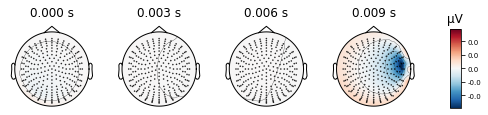

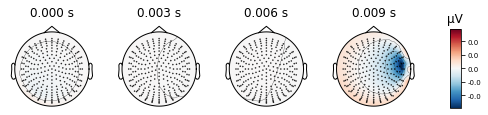

In [195]:
from esinet.util import get_eeg_from_source
evoked_hat = get_eeg_from_source(stc_hat, fwd, info, tmin=stc.tmin)
evoked_hat.plot_topomap()

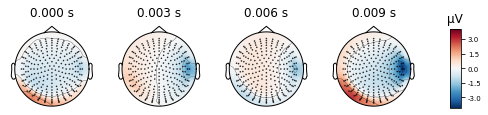

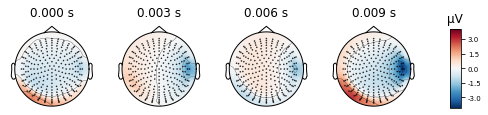

In [196]:
evoked.plot_topomap()